Load our python libraries

In [1]:

import pandas as pd 
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import matplotlib.colors as clr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.cluster.vq import kmeans2, whiten
import seaborn as sns



Load the squirrel data into a pandas dataframe and take a looks at the columns

In [2]:

df_squirrel = pd.read_csv("squirrel_data.csv")
print('Row count:',len(df_squirrel))
print('Columns:\n',df_squirrel.dtypes)


Row count: 3023
Columns:
 X                                             float64
Y                                             float64
Unique Squirrel ID                             object
Hectare                                        object
Shift                                          object
Date                                            int64
Hectare Squirrel Number                         int64
Age                                            object
Primary Fur Color                              object
Highlight Fur Color                            object
Combination of Primary and Highlight Color     object
Color notes                                    object
Location                                       object
Above Ground Sighter Measurement               object
Specific Location                              object
Running                                          bool
Chasing                                          bool
Climbing                                         bool
Ea

Calculate percentage of squirrels that approach

Percent of squirrels approaching:5.89%


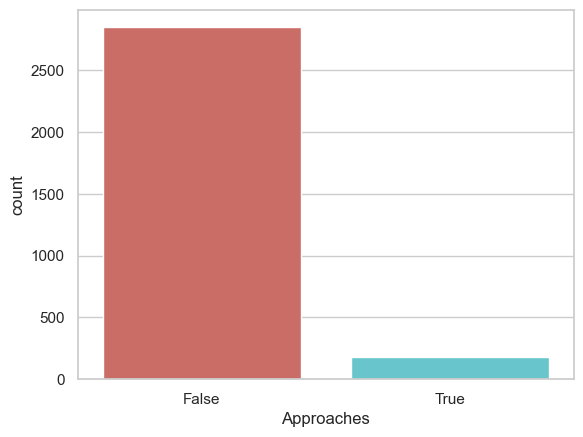

In [10]:

plt.rc("font", size=14)

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

counts = df_squirrel['Approaches'].value_counts()
perc_squirrel = '{:.2%}'.format(counts[1]/counts.sum())
print(f'Percent of squirrels approaching:{perc_squirrel}')
# Show a plot of squirrels that approach
sns.countplot(x='Approaches',data=df_squirrel,palette='hls')
plt.show()

Create a map plotting the points of approaching squirrels

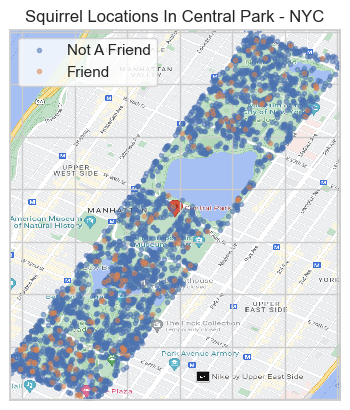

In [5]:
sq_groups = df_squirrel.groupby('Approaches')
# tried to do a map overlay.
extent = df_squirrel['X'].min()   , df_squirrel['X'].max()   , df_squirrel['Y'].min() , df_squirrel['Y'].max() 
im = plt.imread('cp14.png')
implot = plt.imshow(im,interpolation='nearest',
                 extent=extent)
for name, group in sq_groups:
    plt.plot(group.X,group.Y,marker='o',linestyle='',markersize=3,label=name, alpha=.5)
plt.title('Squirrel Locations In Central Park - NYC')

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.legend(labels=['Not A Friend','Friend'])

plt.show()

Create clusters and map them

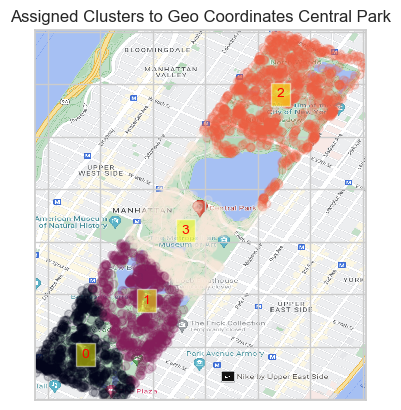

In [7]:
coordinates= df_squirrel[['X','Y']]
xloc, location = kmeans2(whiten(coordinates), 4, seed=50 )  # iter = 20,

extent = df_squirrel['X'].min()   , df_squirrel['X'].max()   , df_squirrel['Y'].min() , df_squirrel['Y'].max() 
im = plt.imread('cp14.png')
implot = plt.imshow(im,interpolation='nearest',
                 extent=extent)
plt.scatter(coordinates['X'], coordinates['Y'], c=location, alpha=.2)

df_squirrel['cluster'] = location
for i in np.unique(location):
    coords = df_squirrel[(df_squirrel.cluster == i)]
    long = coords['X'].median()
    lat = coords['Y'].median()
    plt.text(x=long,y=lat,s=i, 
          fontdict=dict(color='red',size=10),
          bbox=dict(facecolor='yellow',alpha=0.5))
plt.title('Assigned Clusters to Geo Coordinates Central Park')

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.show()

Create our dummy variables

In [11]:
cat_vars = []
for col_name in df_squirrel.columns:
    if col_name not in ['Lat/Long','Other Interactions','Other Activities','Specific Location','Location','Color notes','X','Y','Unique Squirrel ID', 'Hectare', 'Shift', 'Date','Hectare Squirrel Number','Combination of Primary and Highlight Color','Above Ground Sighter Measurement']:
        cat_vars.append(col_name)
df_final_squirrel = pd.get_dummies(df_squirrel.astype(str)[cat_vars],drop_first=True)
        

Oversample to balance the dataset

In [9]:

X = df_final_squirrel

y = df_squirrel['Approaches']
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(random_state=36)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Approaches'])
# we can Check the numbers of our data

print("length of oversampled data is ",len(os_data_X))
print("Number of no Approaches in oversampled data",len(os_data_y[os_data_y['Approaches']==0]))
print("Number of Approaches",len(os_data_y[os_data_y['Approaches']==1]))


length of oversampled data is  3990
Number of no Approaches in oversampled data 1995
Number of Approaches 1995


Remove columns with high variance

In [14]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

min_variance = .001
low_variance = variance_threshold_selector(os_data_X, min_variance) 
print('columns removed:')
os_data_X.columns.delete([*range(0,len(low_variance.columns))])


columns removed:


Index(['cluster_2', 'cluster_3'], dtype='object')

Run our model to get the summary output

In [16]:
import statsmodels.api as sm

y=os_data_y['Approaches']
X=os_data_X.drop(columns=['Approaches_True'])

logit_model=sm.Logit(y.astype(float),X.astype(float))
result=logit_model.fit()
display(result.summary2())

         Current function value: 0.461959
         Iterations: 35


c:\Users\bryan\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                                                     Results: Logit
========================================================================================================================================================================================================================
Model:                                                                  Logit                                                              Pseudo R-squared:                                                   0.334    
Dependent Variable:                                                     Approaches                                                         AIC:                                                                3748.4344
Date:                                                                   2023-02-12 16:02                                                   BIC:                                                                3943.4724
No. Observations:                                                       3990                                                               Log-Likelihood:                                                     -1843.2  
Df Model:                                                               30                                                                 LL-Null:                                                            -2765.7  
Df Residuals:                                                           3959                                                               LLR p-value:                                                        0.0000   
Converged:                                                              0.0000                                                             Scale:                                                              1.0000   
No. Iterations:                                                         35.0000                                                                                                                                         
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                             Coef.                       Std.Err.                        z     P>|z|                        [0.025                                           0.975]                     
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_Adult                                    -1.7813                                           1.1027  -1.6154 0.1062                                           -3.9425                                           0.3799
Age_Juvenile                                 -1.4752                                           1.1059  -1.3340 0.1822                                           -3.6427                                           0.6922
Age_nan                                      -3.0685                                           1.1328  -2.7087 0.0068                                           -5.2888                                          -0.8482
Primary Fur Color_Cinnamon                    0.0491                                           0.2751   0.1784 0.8584                                           -0.4901                                           0.5883
Primary Fur Color_Gray                       -0.4502                                           0.2250  -2.0013 0.0454                                           -0.8912                                          -0.0093
Primary Fur Color_nan                        -0.4406                                           0.3875  -1.1368 0.2556                             

Only use columns that have p-value less than .05

In [29]:
columns_to_use = result.pvalues[(result.pvalues <.05)]
print('Our columns to use for predictions:')
columns_to_use.index

Our columns to use for predictions:


Index(['Age_nan', 'Primary Fur Color_Gray',
       'Highlight Fur Color_Black, Cinnamon, White',
       'Highlight Fur Color_Cinnamon', 'Highlight Fur Color_Cinnamon, White',
       'Highlight Fur Color_Gray', 'Highlight Fur Color_Gray, White',
       'Highlight Fur Color_White', 'Running_True', 'Chasing_True',
       'Eating_True', 'Foraging_True', 'Kuks_True', 'Tail flags_True',
       'Tail twitches_True', 'Indifferent_True', 'Runs from_True', 'cluster_1',
       'cluster_3'],
      dtype='object')

<AxesSubplot:>

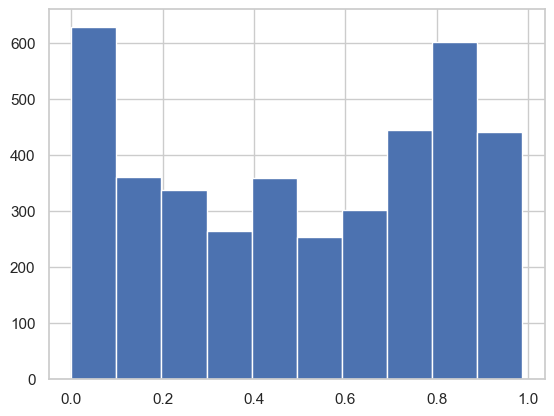

In [30]:
proba = 1 / (1 + np.exp( - result.fittedvalues))
proba.hist()

Run our regression and obtain the accuracy

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X[columns_to_use.index].astype(float), y.astype(float), test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))


Accuracy of logistic regression classifier on test set: 0.77
Accuracy of logistic regression classifier on train set: 0.76


Explain the accuracy with a confusion matrix

In [72]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[464 127]
 [148 458]]


In [73]:
(464 + 458)/(464+127+148+458)

0.7702589807852965

Calculate ROC Curve and display it

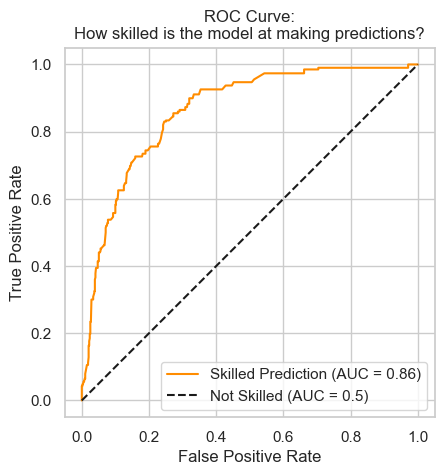

In [65]:
from sklearn.metrics import RocCurveDisplay

y_pred_proba = logreg.predict_proba(X_test)[::,1]



RocCurveDisplay.from_predictions(
    y_test,
    y_pred_proba,
    name="Skilled Prediction",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="Not Skilled (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve:\nHow skilled is the model at making predictions?")
plt.legend()
plt.show()

Assign the probabilities to our original data

In [66]:
df_squirrel['prob'] = logreg.predict_proba(df_final_squirrel[columns_to_use.index])[::,1]

The following is an attempt to increase the density of our map so we can see the red probabilities better. There might be a better way

In [68]:


def increase_density(num, perc):
    perc = round(perc * 1000)
    arr = [] 
    for i in range(1,perc + 1):
        arr.append(num)
    return arr


In [69]:
# increase the density of X and Y based on probability
xden = [] 
yden = []

for index,row in df_squirrel.iterrows():
    for i in increase_density(row['X'],row['prob'] ):
        xden.append(i)
    for i in increase_density(row['Y'],row['prob'] ):
        yden.append(i)
    #xden.append(increase_density(row['X'],row['prob'] ))
    #yden.append(increase_density(row['Y'],row['prob'] ))


Show our friendly squirrel density 

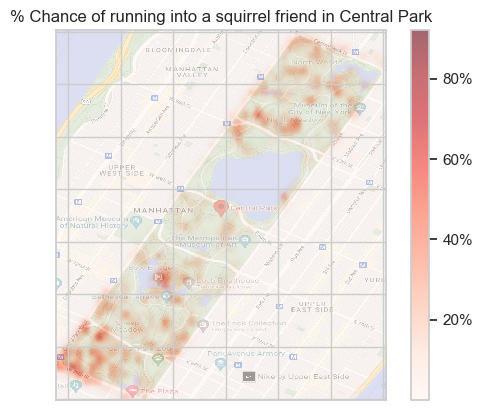

In [70]:

heatmap, xedges, yedges = np.histogram2d(xden, yden, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


plt.clf()

im = plt.imread('cp14.png')
implot = plt.imshow(im,interpolation='nearest',
                 extent=extent)
#cmap = clr.LinearSegmentedColormap.from_list("", ["white","white","red","firebrick","darkred","black"])

plt.imshow(heatmap.T, extent=extent, origin='lower', alpha=.6,interpolation = 'gaussian' , cmap='Reds') 
#plt.colorbar()
cbar = plt.colorbar()
cbar.set_ticks([*range(2000,10000,2000)])
cbar.set_ticklabels(["20%", "40%", "60%", "80%"])

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.title('% Chance of running into a squirrel friend in Central Park')
plt.show()